In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import numba
from numba import njit,jit

In [2]:
dens = xr.open_dataset('woa18_A5B7_I00_04.nc',decode_times=False).I_an [0,:,:,:]
temp = xr.open_dataset('woa18_A5B7_t00_04.nc',decode_times=False).t_an [0,:,:,:]
salt = xr.open_dataset('woa18_A5B7_s00_04.nc',decode_times=False).s_an [0,:,:,:]

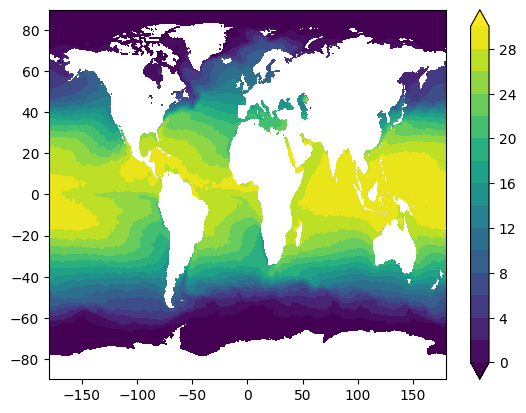

In [3]:
plt.contourf(dens['lon'],dens['lat'],temp[0,:,:],levels=20,extend='both')
plt.colorbar()

Text(0.5, 1.0, 'Salinity')

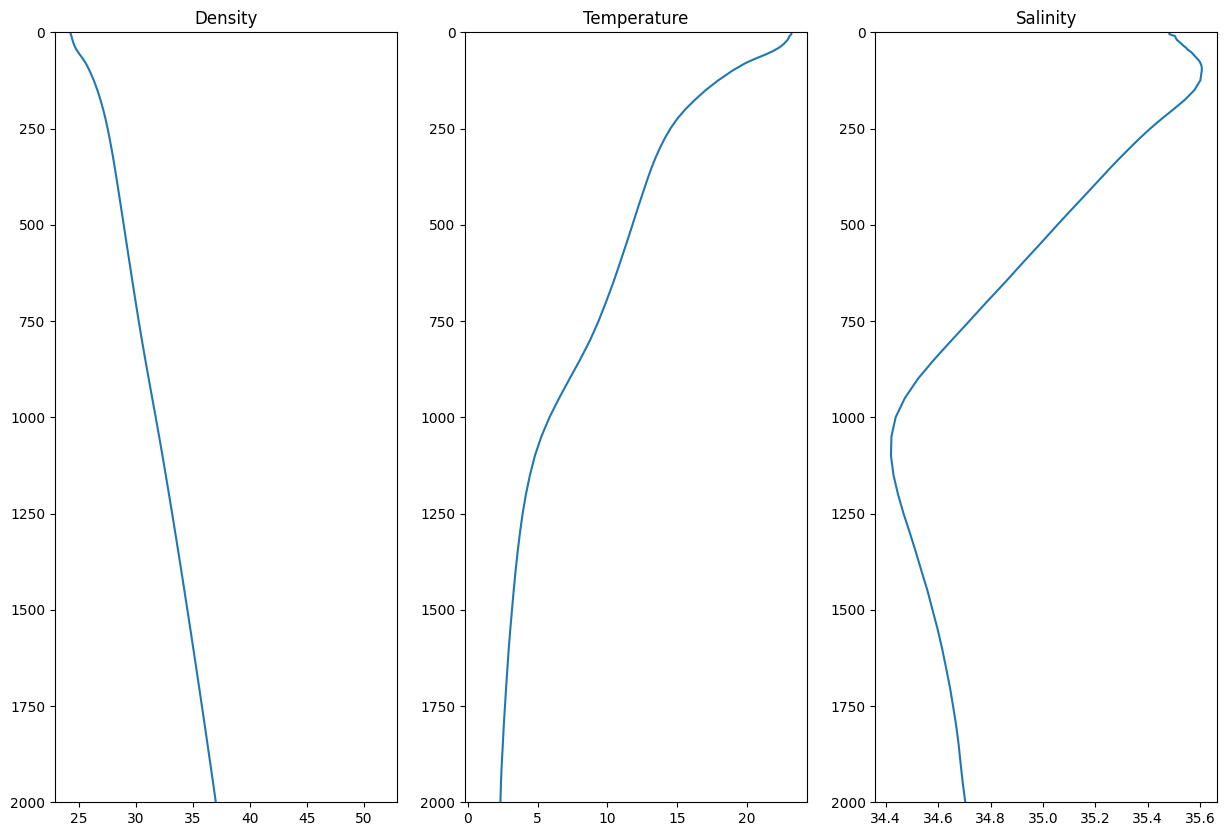

In [4]:
dens_iosg = dens.sel(lat=-28,lon=60,method='nearest')
temp_iosg = temp.sel(lat=-28,lon=60,method='nearest')
salt_iosg = salt.sel(lat=-28,lon=60,method='nearest')

fig, axs = plt.subplots(nrows=1,ncols=3,
                        figsize=(15,10))
axs[0].plot(dens_iosg,dens_iosg['depth'])
axs[0].set_ylim(2000,0)
axs[0].set_title('Density')

axs[1].plot(temp_iosg,temp_iosg['depth'])
axs[1].set_ylim(2000,0)
axs[1].set_title('Temperature')

axs[2].plot(salt_iosg,salt_iosg['depth'])
axs[2].set_ylim(2000,0)
axs[2].set_title('Salinity')


Text(0.5, 1.0, 'Salinity')

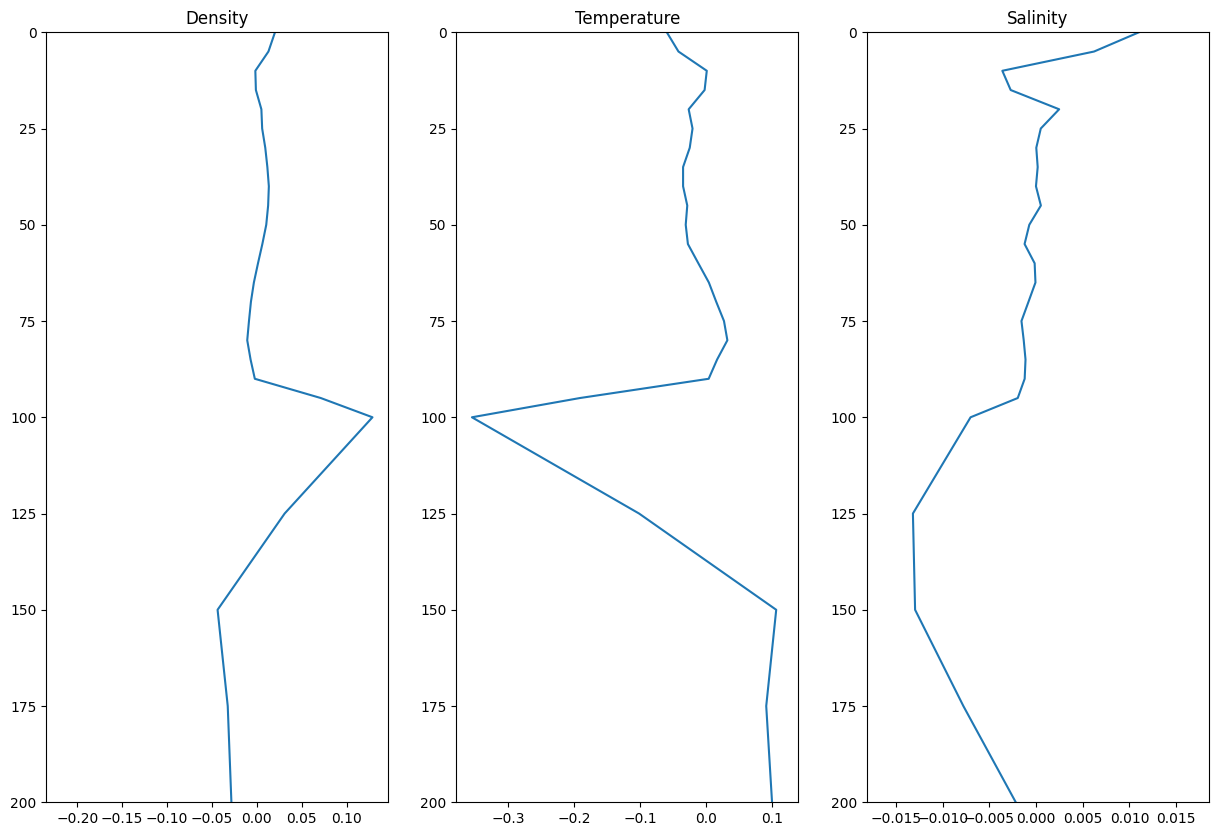

In [5]:
dens_iosg = dens.sel(lat=-28,lon=60,method='nearest')
temp_iosg = temp.sel(lat=-28,lon=60,method='nearest')
salt_iosg = salt.sel(lat=-28,lon=60,method='nearest')

fig, axs = plt.subplots(nrows=1,ncols=3,
                        figsize=(15,10))
axs[0].plot(np.gradient(np.gradient(dens_iosg,axis=0),axis=0),dens_iosg['depth'])
axs[0].set_ylim(200,0)
axs[0].set_title('Density')

axs[1].plot(np.gradient(np.gradient(temp_iosg,axis=0),axis=0),temp_iosg['depth'])
axs[1].set_ylim(200,0)
axs[1].set_title('Temperature')

axs[2].plot(np.gradient(np.gradient(salt_iosg,axis=0),axis=0),salt_iosg['depth'])
axs[2].set_ylim(200,0)
axs[2].set_title('Salinity')


In [6]:
import numpy as np

def compute_thermocline_depth(z, T):
    
    """
    Compute thermocline depth using the maximum temperature gradient method.
    """
    
    sorted_indices = np.argsort(z)
    z, T = z[sorted_indices], T[sorted_indices]
    
    dTdz = np.gradient(T, z)
    
    # Restrict search between 10m and 1000m to avoid surface noise
    mask = (z >= 10) & (z <= 1000)
    z_masked, dTdz_masked = z[mask], dTdz[mask]
    
    # Find depth of maximum temperature gradient
    thermocline_depth = z_masked[np.argmax(np.abs(dTdz_masked))] if len(z_masked) > 0 else np.nan
    
    return thermocline_depth

if __name__ == "__main__":
    z = temp_iosg['depth'].values  # Depth profile
    T = temp_iosg.values  # Temperature profile
    
    thermocline_depth = compute_thermocline_depth(z, T)
    
    print(f"Thermocline depth (gradient method): {thermocline_depth:.2f} m")


Thermocline depth (gradient method): 65.00 m


In [8]:
t_cline_depth = np.zeros((720,1440))

for i in range(0,720):
    for j in range(0,1440):
        t_cline_depth[i,j] = compute_thermocline_depth(temp[:,i,j]['depth'].values,temp[:,i,j].values)

In [10]:
thermo_cline_depth = temp[0,:,:]*0 + t_cline_depth

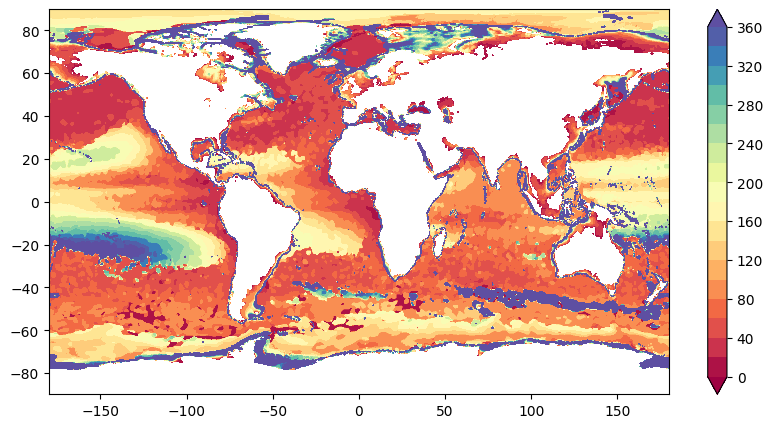

In [14]:
plt.figure(figsize=(10,5))
plt.contourf(temp['lon'],temp['lat'],thermo_cline_depth,np.arange(0,380,20),cmap='Spectral',extend='both')
plt.colorbar()